In [ ]:
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from Signal_Analysis.features import signal


def extract_long_audio_features(y, sr):
    # Load the audio file
#     y, sr = librosa.load(file_path)
    
    # Initialize the features list
    features = []
    
#     # Amplitude Envelope
#     amplitude_envelope = np.abs(librosa.amplitude_to_db(y))
#     features.extend(amplitude_envelope)
#     print(amplitude_envelope.shape)
    
    # Energy
    energy = np.sum(y ** 2)
    features.append(energy)
    
    # Zero-Crossing Rate (ZCR)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y)[0])
    features.append(zcr)
    
    # RMS Energy
    rms = np.mean(librosa.feature.rms(y=y)[0])
    features.append(rms)

    
#     # Short-time Energy
#     frame_length = 1024
#     hop_length = 512
#     ste = np.array([sum(abs(y[i:i+frame_length])**2) for i in range(0, len(y), hop_length)])
#     features.extend(ste)
    
#     # Autocorrelation
#     autocorr = np.correlate(y, y, mode='full')[len(y)-1:]
#     print(autocorr.shape)
#     features.extend(autocorr)
    
    # Peak Value
    peak_value = np.max(np.abs(y))
    features.append(peak_value)
    
    # Formants
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch.append(pitches[index, t])
    pitch = np.array(pitch)
    pitch = pitch[pitch > 0]
    num_formants = min(5, len(pitch))
    formants = sorted(pitch)[:num_formants]
    features.extend(formants)
    
    # Spectral Centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0])
    features.append(spectral_centroid)
    
    # Spectral Bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)[0])
    features.append(spectral_bandwidth)

    # Spectral Flatness
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y)[0])
    features.append(spectral_flatness)
    
    # Spectral Rolloff
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)[0])
    features.append(spectral_rolloff)
    
    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    features.extend(spectral_contrast)
    
    
    # Harmonics-to-Noise Ratio (HNR)
    hnr = np.mean(librosa.effects.harmonic(y) / (librosa.effects.percussive(y) + 1e-10))
    features.append(hnr)
    
    # Mel-Frequency Cepstral Coefficients (MFCCs)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)
    features.extend(mfccs)
    
    # Fundamental Frequency
    f0 = np.mean(librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')))
    features.append(f0)
    
    
    
    # Perform FFT
    fft_result = np.fft.rfft(y)
    fft_frequencies = np.fft.rfftfreq(len(y), d=1/sr)

    # Compute power spectrum
    power_spectrum = np.abs(fft_result)**2

    # Identify the cutoff index for 8 kHz
    cutoff_index = np.where(fft_frequencies >= 6000)[0][0]

    # Calculate power below and above 8 kHz
    power_below_8kHz = np.sum(power_spectrum[:cutoff_index])
    power_above_8kHz = np.sum(power_spectrum[cutoff_index:])
    features.append(power_below_8kHz)
    features.append(power_above_8kHz)
    
    
    # LH1000 Ratio
    # Identify the cutoff indices for 1 kHz and 8 kHz
    cutoff_index_1kHz = np.where(fft_frequencies >= 1000)[0][0]
    cutoff_index_8kHz = np.where(fft_frequencies >= 6000)[0][0]

    # Calculate power in the desired frequency bands
    power_0_to_1kHz = np.sum(power_spectrum[:cutoff_index_1kHz])
    power_1_to_8kHz = np.sum(power_spectrum[cutoff_index_1kHz:cutoff_index_8kHz])

    # Calculate the energy ratio (LH1000)
    LH1000 = power_0_to_1kHz / power_1_to_8kHz if power_1_to_8kHz != 0 else 0
    features.append(LH1000)
    
    
#     cutoff_index = np.where(fft_frequencies >= 16000)[0][0]
#     power_above_16kHz = np.sum(power_spectrum[cutoff_index:])
#     features.append(power_above_16kHz)
    
    
    
    ## HNR
    HNR = signal.get_HNR( y, sr )
    features.append(HNR)
    
   

    return features




In [230]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import os
import glob

# File paths
wav_files = glob.glob("ComParE2020_Mask/wav/*.wav")
label_file = 'Mask_labels_confidential.csv'

# Read the label file
labels_df = pd.read_csv(label_file)

# Function to segment audio files
def segment_audio(file_path, segment_length=1, overlap=0):
#     sr, y = wavfile.read(file_path)
    
    y, sr = librosa.load(file_path, sr=None)

    y, _ = librosa.effects.trim(y, top_db=20)

    segment_length_samples = int(segment_length * sr)
    overlap_samples = int(overlap * sr)
    segments = []

    for start in range(0, len(y), segment_length_samples - overlap_samples):
        end = min(start + segment_length_samples, len(y))
        segments.append(y[start:end])

    return segments, sr

# Function to extract MFCC features
def extract_features(segments, sr):
    features = []
    for segment in segments:
        if len(segment) == 0:
            continue
        feat = extract_long_audio_features(segment, sr=sr)
        print(len(feat))
        if len(feat)!=46:
            continue
#         mfcc_mean = np.mean(mfcc, axis=1)
        features.append(feat)
    return np.array(features)

# Process each audio file and extract features
all_features = []
all_labels = []

for file_path in wav_files:
    segments, sr = segment_audio(file_path)
    file_name = os.path.basename(file_path)

    # Retrieve labels for this file
    file_labels = labels_df[labels_df['file_name'] == file_name]['label'].values

    features  = extract_features(segments, sr)
    

    all_features.extend(features)
    print(features.shape)
    labels = []
    for i in range(len(features)):
        labels.append(file_labels[0])
        
    all_labels.extend(labels)

all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Checking the shapes of the features and labels
all_features.shape, all_labels.shape


46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: divide by zero encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/peakutils/peak.py:43: RuntimeWarning: invalid value encountered in double_scalars
  thres = thres * (np.max(y) - np.min(y)) + np.min(y)


46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:1292: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


46
(1, 46)
46
(1, 46)
46
(1, 46)


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: invalid value encountered in true_divide
  r_x = r_a / r_w


46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1664
  return f(*args, **kwargs)


46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)

46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)

46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1152
  return f(*args, **kwargs)


44
(0,)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
45
(0,)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1

46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)

46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)

46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)

46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)

46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)
46
(1, 46)

KeyboardInterrupt: 

In [ ]:
# np.save('Long_features.npy', all_features)
# np.save('Long_labels.npy', all_labels)


all_features = np.load('Long_features.npy')
all_labels = np.load('Long_labels.npy')




In [252]:
all_features.shape

(91082, 46)

In [253]:
# all_features = np.array(all_features)
X = np.array(all_features)
X_min = np.min(X)
X_max = np.max(X)
X_norm = (X - X_min) / (X_max - X_min)

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, all_labels, test_size=0.2, random_state=42)


In [255]:
# X_train = np.reshape(X_train, (X_train.shape[0], 42))
X_train

array([[0.04040018, 0.04035413, 0.04035415, ..., 0.04040126, 0.04036682,
        0.04035644],
       [0.04044312, 0.04035412, 0.04035416, ..., 0.0403638 , 0.04036009,
        0.04035678],
       [0.04038723, 0.04035413, 0.04035414, ..., 0.04040664, 0.0403558 ,
        0.0403563 ],
       ...,
       [0.04040199, 0.04035414, 0.04035415, ..., 0.04047896, 0.040362  ,
        0.04035641],
       [0.04038774, 0.04035413, 0.04035414, ..., 0.04037708, 0.04036365,
        0.04035596],
       [0.04038882, 0.04035413, 0.04035414, ..., 0.04037069, 0.04036166,
        0.04035633]])

In [256]:
# all_features.shape, all_features[2].shape, len(all_labels)
# all_features = np.reshape(all_features, (all_features.shape[0], 42))


X_test = X_test.astype(np.float)
X_train = X_train.astype(np.float)

X_test = np.nan_to_num(X_test)
X_train = np.nan_to_num(X_train)

/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_10189/3569962390.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = X_test.astype(np.float)
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_10189/3569962390.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = X_train.astype(np.float)


In [257]:
# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)



In [258]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)



Accuracy: 62.09%


In [259]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       clear       0.61      0.58      0.59      8733
        mask       0.63      0.66      0.64      9484

    accuracy                           0.62     18217
   macro avg       0.62      0.62      0.62     18217
weighted avg       0.62      0.62      0.62     18217



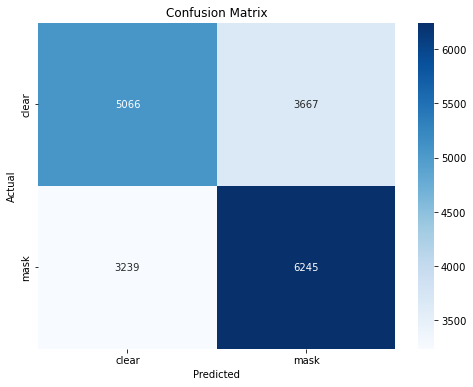

In [260]:
classes = np.unique(y_test)

import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [261]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

import matplotlib.pyplot as plt



precision: [0.60999398 0.63004439]
recall: [0.58009848 0.65847744]
fscore: [0.59467074 0.64394721]
support: [8733 9484]


In [262]:
from sklearn.metrics import confusion_matrix

def calculate_uar(y_true, y_pred):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # True Positives for each class
    tp_mask = cm[0, 0]  # Assuming 'mask' is the first class
    tp_clear = cm[1, 1]  # Assuming 'clear' is the second class

    # Total number of actual instances for each class
    n_mask = sum(cm[0, :])
    n_clear = sum(cm[1, :])

    # Calculate UAR
    uar = 0.5 * (tp_mask / n_mask + tp_clear / n_clear)
    return uar

# Example usage
# y_true = [actual labels]
# y_pred = [predicted labels]
uar = calculate_uar(y_test, y_pred)

uar


0.6192879563611278

In [ ]:
##Feature Importances

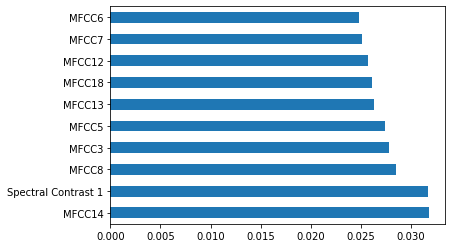

In [243]:
# Sort the features based on the aggregated importance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer

# Updated Feature names
# feature_names = ['energy', 'ZCR', 'RMS', 'peak value', 'formant1', 'formant2', 'formant3', 'formant4', 'formant5', 'spectral centroid', 'spectral BW', 'spectral flatness', 'spectral rolloff'] + [f'spectral contrast{i}' for i in range(1, 8)] + ['HNR'] 
# Let's assume model, X, y are already defined
# model = RandomForestClassifier()
# model.fit(X, y)
feature_names = [
    "Energy",
    "Zero-Crossing Rate",
    "RMS Energy",
    "Peak Value",
    "Formant 1",
    "Formant 2",
    "Formant 3",
    "Formant 4",
    "Formant 5",
    "Spectral Centroid",
    "Spectral Bandwidth",
    "Spectral Flatness",
    "Spectral Rolloff",
    "Spectral Contrast 1",
    "Spectral Contrast 2",
    "Spectral Contrast 3",
    "Spectral Contrast 4",
    "Spectral Contrast 5",
    "Spectral Contrast 6",
    "Spectral Contrast 7",
    "Harmonics-to-Noise Ratio"] + [f'MFCC{i}' for i in range(1, 21)] + [ "Fundamental Frequency",
    "Power Below 8 kHz",
    "Power Above 8 kHz",
    "LH1000 Ratio",
    "HNR (second definition)"]


X = all_features
y = all_labels

feat_importances = pd.Series(clf.feature_importances_, index=feature_names)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


In [140]:
import IPython

file = 'ComParE2020_Mask/wav/devel_00009.wav'
y, sr = librosa.load('ComParE2020_Mask/wav/devel_00001.wav', sr=None)

y, _ = librosa.effects.trim(y, top_db=20)

IPython.display.Audio(file)

16000

In [263]:
import librosa
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pydub import AudioSegment

# File paths
mask_files = [
    'Abhay_mask.m4a',
    'Bhawana_mask.m4a',
    'S1_mask.m4a',
    'S4_mask.m4a',
    'S5_mask.m4a'
]
no_mask_files = [
    'Abhay_noMask.m4a',
    'Bhawana_noMask.m4a',
    'S1_noMask.m4a',
    'S4_noMask.m4a',
    'S5_noMask.m4a'
]

# def segment_and_extract_features(file_name, frame_length=500, overlap=100):
#     audio = AudioSegment.from_file(file_name, format="m4a")
#     total_length = len(audio)
#     step = frame_length - overlap
    
#     features = []
    
#     for start in range(0, total_length - frame_length + 1, step):
#         end = start + frame_length
#         segment = audio[start:end]
        
#         samples = np.array(segment.get_array_of_samples())
#         mfcc = librosa.feature.mfcc(samples, sr=sr, n_mfcc=n_mfcc)
#         mfcc_mean = np.mean(mfcc, axis=1)
#         feature_vector = extract_mfcc_from_frame(samples)
#         features.append(feature_vector)
    
#     return features

# Extract segmented features using the pydub method
all_features = []
all_labels = []
for i in mask_files:
        segments, sr = segment_audio(i)
        features = extract_features(segments, sr)
        labels = []
        for i in range(len(features)):
            labels.append('mask')
        
        all_features.extend(features)
        all_labels.extend(labels)
        
for i in no_mask_files:
        segments, sr = segment_audio(i)
        features = extract_features(segments, sr)
        labels = []
        for i in range(len(features)):
            labels.append('clear')
        
        all_features.extend(features)
        all_labels.extend(labels)
        

    
# mask_segmented_features = [extract_features(f) for f in mask_files]
# no_mask_segmented_features = [extract_features(f) for f in no_mask_files]

# # Flatten the segmented feature lists and prepare the labels
# X_segmented = [item for sublist in mask_segmented_features for item in sublist] + [item for sublist in no_mask_segmented_features for item in sublist]
# y_segmented = [1 for _ in range(len([item for sublist in mask_segmented_features for item in sublist]))] + [0 for _ in range(len([item for sublist in no_mask_segmented_features for item in sublist]))]

# len(X_segmented), len(y_segmented)


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
41
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: divide by zero encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: divide by zero encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: invalid value encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: invalid value encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46


In [249]:
X = np.array(all_features)
X_min = np.min(X)
X_max = np.max(X)
X_norm = (X - X_min) / (X_max - X_min)

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, all_labels, test_size=0.2, random_state=42)


y_pred =clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy



0.5041666666666667

In [265]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)

cm


Accuracy: 62.09%


array([[5066, 3667],
       [3239, 6245]])

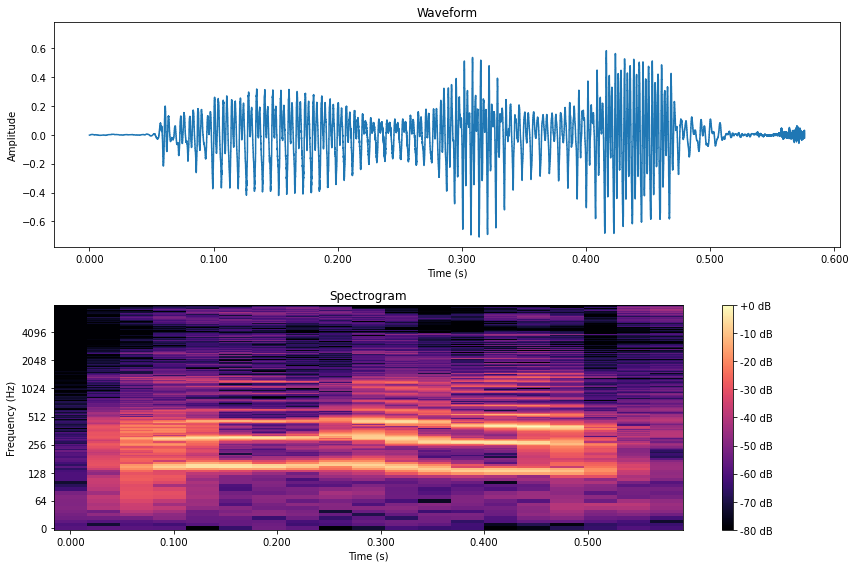

In [220]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
file_path = 'ComParE2020_Mask/wav/train_00005.wav'  # Replace with your audio file path
y, sr = librosa.load(file_path, sr=None)
y, _ = librosa.effects.trim(y, top_db=20)

# Plot the waveform
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Compute and plot the spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.subplot(2, 1, 2)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


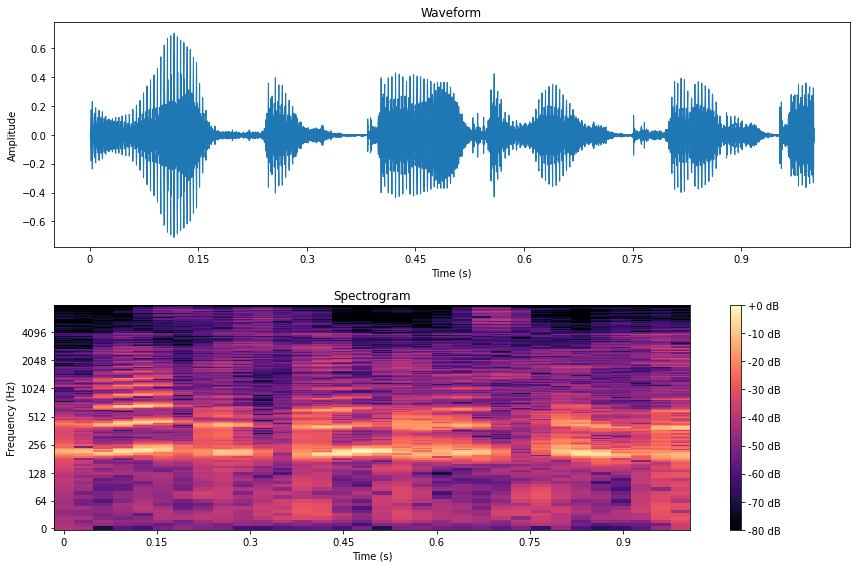

In [153]:
# Load the audio file
file_path = 'ComParE2020_Mask/wav/train_00003.wav'  # Replace with your audio file path
y, sr = librosa.load(file_path, sr=None)

# Plot the waveform
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Compute and plot the spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.subplot(2, 1, 2)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


In [152]:
labels_df

,file_name,label,orig_file_name,corpus_file_name
0,train_00001.wav,clear,train_3625_00.wav,m_prob25_clear_read002_29_#2.7.wav
1,train_00002.wav,clear,train_1124_00.wav,f_prob11_clear_freespeech011_20_#3.6.wav
2,train_00003.wav,mask,train_2430_01.wav,f_prob17_mask_freespeech003_4_#3.8.wav
3,train_00004.wav,clear,train_0839_02.wav,f_prob07_clear_freespeech006_5_#4.2.wav
4,train_00005.wav,clear,train_3145_00.wav,m_prob15_clear_freespeech007_1_#4.9.wav
...,...,...,...,...
36549,test_11008.wav,mask,test_2618_03.wav,f_prob30_mask_freespeech011_18_#5.8.wav
36550,test_11009.wav,clear,test_0212_00.wav,f_prob30_clear_freespeech011_116_#4.3.wav
36551,test_11010.wav,clear,test_2631_00.wav,f_prob10_clear_read002_31_#1.1.wav
36552,test_11011.wav,clear,test_3007_07.wav,f_prob22_clear_freespeech007_3_#9.1.wav
